<a href="https://colab.research.google.com/github/VorobyvEgor/Seminar_Sber/blob/main/Seminars/%D0%97%D0%B0%D0%BD%D1%8F%D1%82%D0%B8%D0%B5_10_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Данные
Для демонстраций загрузим набор данных [Automobile Data Set](https://archive.ics.uci.edu/ml/datasets/Automobile). В данных присутствуют категориальные, целочисленные и вещественнозначные признаки.

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
! wget https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data

--2022-02-17 17:32:05--  https://archive.ics.uci.edu/ml/machine-learning-databases/autos/imports-85.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25936 (25K) [application/x-httpd-php]
Saving to: ‘imports-85.data’

imports-85.data     100%[===================>]  25.33K  --.-KB/s    in 0.07s   

2022-02-17 17:32:06 (346 KB/s) - ‘imports-85.data’ saved [25936/25936]



In [3]:
! ls

imports-85.data  sample_data


In [4]:
data = pd.read_csv("imports-85.data", \
                    header=None,  na_values=["?"])
print(data.shape)
data.head()

(205, 26)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,13495.0
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27,16500.0
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26,16500.0
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30,13950.0
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22,17450.0


In [5]:
data[data[25].isna()]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25
9,0,NaN,audi,gas,turbo,two,hatchback,4wd,front,99.5,178.2,67.9,52.0,3053,ohc,five,131,mpfi,3.13,3.40,7.0,160.0,5500.0,16,22,NaN
44,1,NaN,isuzu,gas,std,two,sedan,fwd,front,94.5,155.9,63.6,52.0,1874,ohc,four,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
45,0,NaN,isuzu,gas,std,four,sedan,fwd,front,94.5,155.9,63.6,52.0,1909,ohc,four,90,2bbl,3.03,3.11,9.6,70.0,5400.0,38,43,NaN
129,1,NaN,porsche,gas,std,two,hatchback,rwd,front,98.4,175.7,72.3,50.5,3366,dohcv,eight,203,mpfi,3.94,3.11,10.0,288.0,5750.0,17,28,NaN


In [6]:
data = data[data[25].notna()]
print(data.shape)

(201, 26)


In [7]:
y = data[25] # цена
print(y.shape)
X = data.drop(25, axis=1)
print(X.shape)

(201,)
(201, 25)


## Предобработка данных
Предобработка данных важна при применении любых методов машинного обучения, а в особенности для линейных моделей. В sklearn предобработку удобно делать с помощью модуля [preprocessing](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.preprocessing) или методов библиотеки pandas.

In [8]:
from sklearn.impute import SimpleImputer
from sklearn import preprocessing

In [9]:
X.dtypes

0       int64
1     float64
2      object
3      object
4      object
5      object
6      object
7      object
8      object
9     float64
10    float64
11    float64
12    float64
13      int64
14     object
15     object
16      int64
17     object
18    float64
19    float64
20    float64
21    float64
22    float64
23      int64
24      int64
dtype: object

In [10]:
cat_features = list(X.dtypes[X.dtypes == "object"].index)
cat_features

[2, 3, 4, 5, 6, 7, 8, 14, 15, 17]

In [13]:
real_features = list(set(X.columns) - set(cat_features))
real_features

[0, 1, 9, 10, 11, 12, 13, 16, 18, 19, 20, 21, 22, 23, 24]

In [14]:
# Для категориальных - пустыми строками
X.loc[:, cat_features] = X.loc[:, cat_features].fillna("")
X.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24
0,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
1,3,NaN,alfa-romero,gas,std,two,convertible,rwd,front,88.6,168.8,64.1,48.8,2548,dohc,four,130,mpfi,3.47,2.68,9.0,111.0,5000.0,21,27
2,1,NaN,alfa-romero,gas,std,two,hatchback,rwd,front,94.5,171.2,65.5,52.4,2823,ohcv,six,152,mpfi,2.68,3.47,9.0,154.0,5000.0,19,26
3,2,164.0,audi,gas,std,four,sedan,fwd,front,99.8,176.6,66.2,54.3,2337,ohc,four,109,mpfi,3.19,3.40,10.0,102.0,5500.0,24,30
4,2,164.0,audi,gas,std,four,sedan,4wd,front,99.4,176.6,66.4,54.3,2824,ohc,five,136,mpfi,3.19,3.40,8.0,115.0,5500.0,18,22


#### Кодирование категориальных переменных
В Sklearn имплементирвоано два основных метода:
* One-hot-encoding - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
* Label_encoding - https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

В pandas: pd.get_dummies()


In [15]:
X_dum = pd.get_dummies(X, drop_first=True)
print(X_dum.shape)
X_dum.head()

(201, 65)


,0,1,9,10,11,12,13,16,18,19,20,21,22,23,24,2_audi,2_bmw,2_chevrolet,2_dodge,2_honda,2_isuzu,2_jaguar,2_mazda,2_mercedes-benz,2_mercury,2_mitsubishi,2_nissan,2_peugot,2_plymouth,2_porsche,2_renault,2_saab,2_subaru,2_toyota,2_volkswagen,2_volvo,3_gas,4_turbo,5_four,5_two,6_hardtop,6_hatchback,6_sedan,6_wagon,7_fwd,7_rwd,8_rear,14_l,14_ohc,14_ohcf,14_ohcv,14_rotor,15_five,15_four,15_six,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
0,3,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
1,3,NaN,88.6,168.8,64.1,48.8,2548,130,3.47,2.68,9.0,111.0,5000.0,21,27,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
2,1,NaN,94.5,171.2,65.5,52.4,2823,152,2.68,3.47,9.0,154.0,5000.0,19,26,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0
3,2,164.0,99.8,176.6,66.2,54.3,2337,109,3.19,3.40,10.0,102.0,5500.0,24,30,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
4,2,164.0,99.4,176.6,66.4,54.3,2824,136,3.19,3.40,8.0,115.0,5500.0,18,22,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0


In [17]:
# Делим на train \ test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dum, y, test_size=0.2, random_state=1)
print(X_train.shape)
print(X_test.shape)

(160, 65)
(41, 65)


### Заполнение пропусков
В матрице объекты-признаки могут быть пропущенные значения, и это вызовет исключение при попытке передать такую матрицу в функцию обучения модели или даже предобработки. Если пропусков немного, можно удалить объекты с пропусками из обучающей выборки. Заполнить пропуски можно разными способами:
* заполнить средними (mean, median);
* предсказывать пропущенные значения по непропущенным.

Последний вариант сложный и применяется редко. Для заполнения константами можно использовать метод датафрейма fillna, для замены средними - класс preprocessing.Imputer.

Заполнение на train выборке

In [18]:
# Для вещественнозначных признаков заполним пропуски средними
X_train_real = X_train[real_features]
mis_replacer = SimpleImputer(strategy="mean")
mis_replacer.fit(X_train_real)

X_train_no_mis = X_train.copy()
X_train_no_mis.loc[:, real_features] = mis_replacer.transform(X_train_real)

In [19]:
print(X_train_no_mis.shape)
X_train_no_mis.head()

(160, 65)


,0,1,9,10,11,12,13,16,18,19,20,21,22,23,24,2_audi,2_bmw,2_chevrolet,2_dodge,2_honda,2_isuzu,2_jaguar,2_mazda,2_mercedes-benz,2_mercury,2_mitsubishi,2_nissan,2_peugot,2_plymouth,2_porsche,2_renault,2_saab,2_subaru,2_toyota,2_volkswagen,2_volvo,3_gas,4_turbo,5_four,5_two,6_hardtop,6_hatchback,6_sedan,6_wagon,7_fwd,7_rwd,8_rear,14_l,14_ohc,14_ohcf,14_ohcv,14_rotor,15_five,15_four,15_six,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
113,0.0,122.416,114.2,198.9,68.4,56.7,3285.0,120.0,3.46,2.19,8.4,95.0,5000.0,19.0,24.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
125,3.0,186.000,94.5,168.9,68.3,50.2,2778.0,151.0,3.94,3.11,9.5,143.0,5500.0,19.0,27.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0
61,1.0,129.000,98.8,177.8,66.5,53.7,2385.0,122.0,3.39,3.39,8.6,84.0,4800.0,26.0,32.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
15,0.0,122.416,103.5,189.0,66.9,55.7,3230.0,209.0,3.62,3.39,8.0,182.0,5400.0,16.0,22.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
59,1.0,129.000,98.8,177.8,66.5,53.7,2385.0,122.0,3.39,3.39,8.6,84.0,4800.0,26.0,32.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0


Заполнение на test выборке

In [20]:
# Для вещественнозначных признаков заполним пропуски средними
X_test_real = X_test[real_features]

X_test_no_mis = X_test.copy()
X_test_no_mis.loc[:, real_features] = mis_replacer.transform(X_test_real)

print(X_test_no_mis.shape)
X_test_no_mis.head()

(41, 65)


,0,1,9,10,11,12,13,16,18,19,20,21,22,23,24,2_audi,2_bmw,2_chevrolet,2_dodge,2_honda,2_isuzu,2_jaguar,2_mazda,2_mercedes-benz,2_mercury,2_mitsubishi,2_nissan,2_peugot,2_plymouth,2_porsche,2_renault,2_saab,2_subaru,2_toyota,2_volkswagen,2_volvo,3_gas,4_turbo,5_four,5_two,6_hardtop,6_hatchback,6_sedan,6_wagon,7_fwd,7_rwd,8_rear,14_l,14_ohc,14_ohcf,14_ohcv,14_rotor,15_five,15_four,15_six,15_three,15_twelve,15_two,17_2bbl,17_4bbl,17_idi,17_mfi,17_mpfi,17_spdi,17_spfi
100,0.0,106.0,97.2,173.4,65.2,54.7,2302.0,120.0,3.33,3.47,8.5,97.0,5200.0,27.0,34.0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
120,1.0,154.0,93.7,157.3,63.8,50.6,1967.0,90.0,2.97,3.23,9.4,68.0,5500.0,31.0,38.0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
62,0.0,115.0,98.8,177.8,66.5,55.5,2410.0,122.0,3.39,3.39,8.6,84.0,4800.0,26.0,32.0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0
36,0.0,78.0,96.5,157.1,63.9,58.3,2024.0,92.0,2.92,3.41,9.2,76.0,6000.0,30.0,34.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
169,2.0,134.0,98.4,176.2,65.6,52.0,2551.0,146.0,3.62,3.50,9.3,116.0,4800.0,24.0,30.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0


Всегда нужно осознавать, случайны ли пропуски в каком-то признаке. Иногда факт отсутствия информации о значении признака может сам быть важным признаком, который необходимо добавить к другим признакам.

__Пример:__ предсказание возраста пользователя по данным с его телефона. Поскольку люди старшего возраста чаще пользуются простыми телефонами, факт отсутствия каких-то данных (например, истории посещенных интернет-страниц), скорее всего, будет хорошим признаком.

Для категориальных признаков рекомендуется создавать отдельную категорию, соответствующую пропущенному значению. В наши данных пропусков в категориальных признаках нет.

In [ ]:
print(X_train_no_mis.shape)
print(X_test_no_mis.shape)

(160, 65)
(41, 65)


### Масштабирование признаков
При начале работы с данными всегда рекомендуется приводить все признаки к одному масштабу.  Это важно по нескольким причинам:
* ускорение обучения модели
* улучшение численной устойчивости при работе с матрицей объекты-признаки (рядом с нулем чисел с плавающей точкой больше, чем с области больших чисел)
* для линейных моделей: интерпретация весов при признаках как меры их значимости

Первый популярный способ масштабирования - нормализация: вычитание среднего из каждого признака и деление на стандартное отклонение (StandardScaler в sklearn). Второй популярный способ: вычитание минимума из каждого признака, а затем деление на разницу максимального и минимального значения (MinMaxScaler в sklearn).

In [21]:
normalizer = preprocessing.MinMaxScaler()
normalizer.fit(X_train_no_mis)

X_real_norm_np = normalizer.transform(X_train_no_mis)
X_train_transformed = pd.DataFrame(data=X_real_norm_np)

X_real_norm_np = normalizer.transform(X_test_no_mis)
X_test_transformed = pd.DataFrame(data=X_real_norm_np)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


In [22]:
print(X_train_transformed.shape)
X_train_transformed.head()

(160, 65)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0.4,0.300607,0.804665,0.862687,0.692308,0.741667,0.697052,0.222642,0.657143,0.057143,0.08750,0.219626,0.346939,0.176471,0.216216,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.0,0.633508,0.230321,0.414925,0.683761,0.200000,0.500388,0.339623,1.000000,0.495238,0.15625,0.443925,0.551020,0.176471,0.297297,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.6,0.335079,0.355685,0.547761,0.529915,0.491667,0.347944,0.230189,0.607143,0.628571,0.10000,0.168224,0.265306,0.382353,0.432432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.300607,0.492711,0.714925,0.564103,0.658333,0.675718,0.558491,0.771429,0.628571,0.06250,0.626168,0.510204,0.088235,0.162162,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.6,0.335079,0.355685,0.547761,0.529915,0.491667,0.347944,0.230189,0.607143,0.628571,0.10000,0.168224,0.265306,0.382353,0.432432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
print(X_test_transformed.shape)
X_test_transformed.head()

(41, 65)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64
0,0.4,0.214660,0.309038,0.482090,0.418803,0.575000,0.315749,0.222642,0.564286,0.666667,0.09375,0.228972,0.428571,0.411765,0.486486,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.6,0.465969,0.206997,0.241791,0.299145,0.233333,0.185803,0.109434,0.307143,0.552381,0.15000,0.093458,0.551020,0.529412,0.594595,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.4,0.261780,0.355685,0.547761,0.529915,0.641667,0.357642,0.230189,0.607143,0.628571,0.10000,0.168224,0.265306,0.382353,0.432432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.4,0.068063,0.288630,0.238806,0.307692,0.875000,0.207913,0.116981,0.271429,0.638095,0.13750,0.130841,0.755102,0.500000,0.486486,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.8,0.361257,0.344023,0.523881,0.452991,0.350000,0.412335,0.320755,0.771429,0.680952,0.14375,0.317757,0.265306,0.323529,0.378378,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


### Добавление признаков
Особенно важным моментом для линейной регрессии является нелинейное преобразование признаков. Это позволяет использовать линейную регрессию для моделирования нелинейных зависимостей. Наиболее популярны следующие преобразования: полиномиальные признаки (PolynomialFeatures в sklearn), взятие логарифма, квадратного корня, применение тригонометрических функий.

Например, в нашем датасете зависимость целевой перемнной от шестого признака скорее квадратичная, чем линейная:

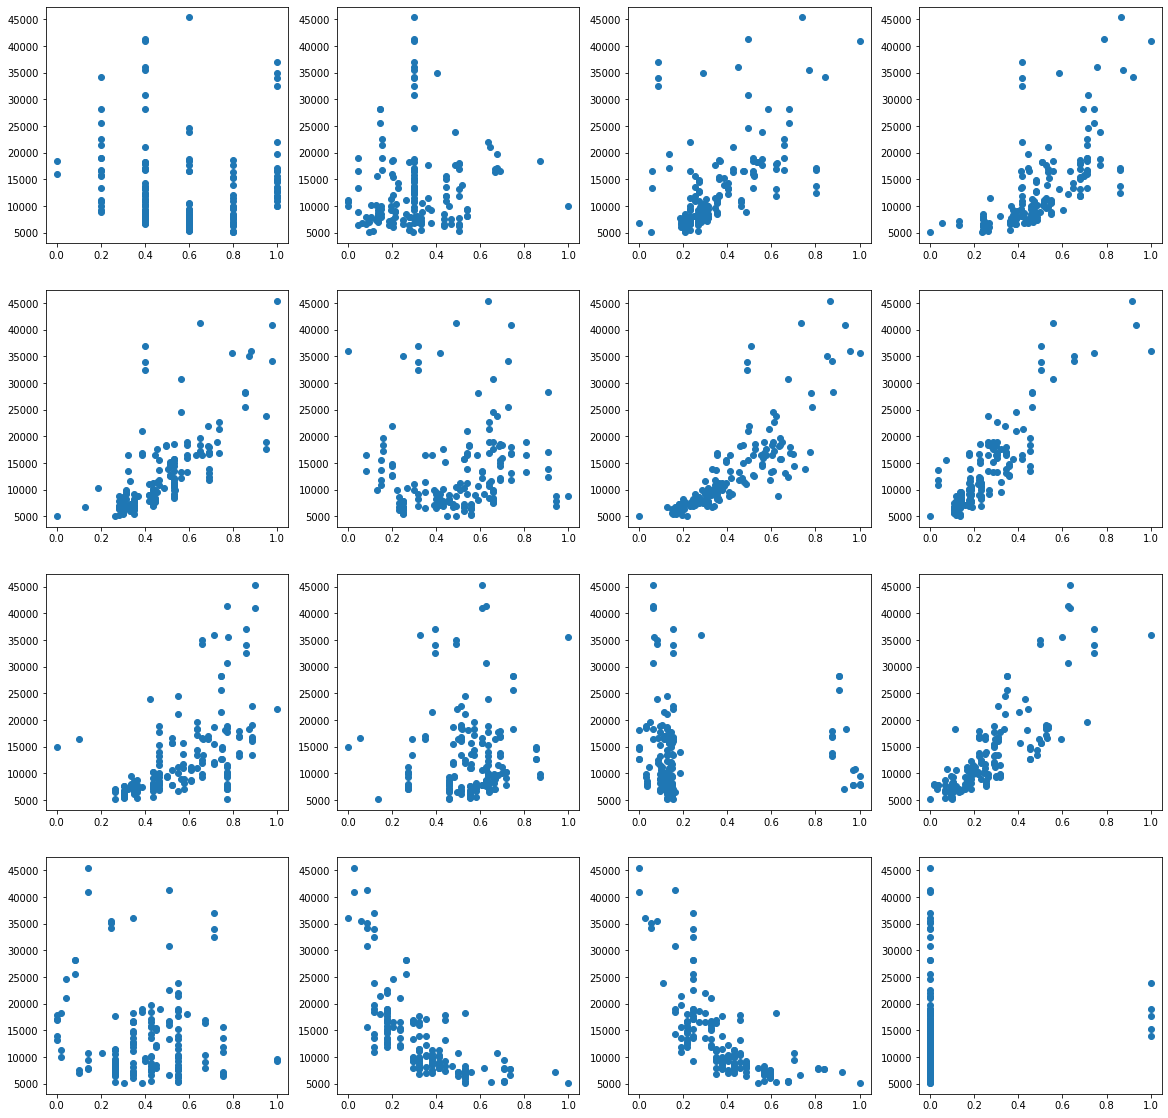

In [24]:
plt.figure(figsize=(20, 20))
for i in range(4):
  for j in range(4):
    plt.subplot(4, 4, i+4*j+1)
    plt.scatter(X_train_transformed[i+4*j], y_train);
# 3, 6, 11 - скорее квадратичные
# 13, 14 - 1/x или  1/sqrt(x)

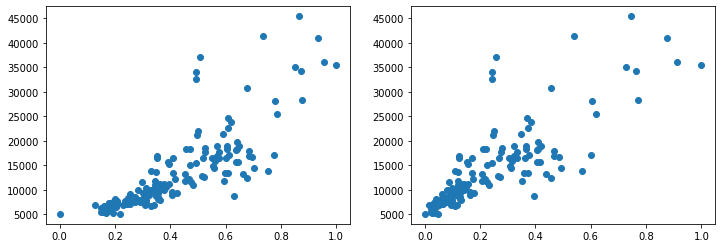

In [25]:
i = 6
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_train_transformed[i], y_train)
plt.subplot(1, 2, 2)
plt.scatter(X_train_transformed[i]**2, y_train);

А для признака номер 13 линеаризовать зависимость получается с помощью функции $\frac 1 {\sqrt{\cdot}}$

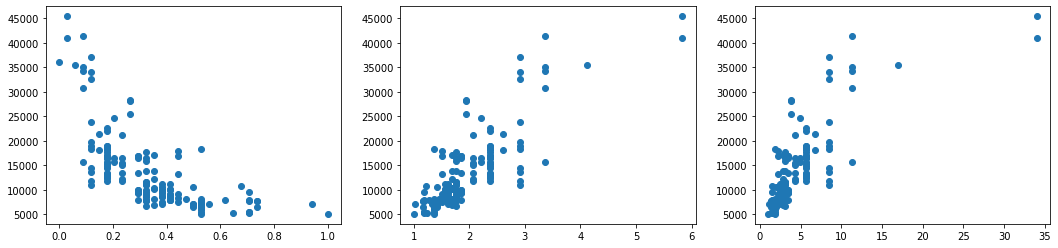

In [26]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.scatter(X_train_transformed[13], y_train)
plt.subplot(1, 3, 2)
plt.scatter(1/np.sqrt(X_train_transformed[13]), y_train)
plt.subplot(1, 3, 3)
plt.scatter(1/X_train_transformed[13], y_train);

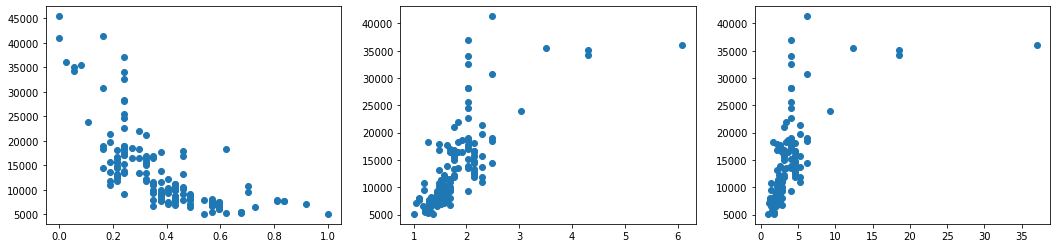

In [27]:
plt.figure(figsize=(18, 4))
plt.subplot(1, 3, 1)
plt.scatter(X_train_transformed[14], y_train)
plt.subplot(1, 3, 2)
plt.scatter(1/np.sqrt(X_train_transformed[14]), y_train)
plt.subplot(1, 3, 3)
plt.scatter(1/X_train_transformed[14], y_train);

Обратите внимание, что при генерации полиномиальных признаков матрица объекты-признаки может занимать очень много памяти.

### Обучаем модель и смотрим качество

In [28]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [30]:
lr = LinearRegression()
lr.fit(X_train_transformed, y_train)

predict_train = lr.predict(X_train_transformed)
predict_test = lr.predict(X_test_transformed)

print(np.sqrt(mean_squared_error(y_train, predict_train)))
print(np.sqrt(mean_squared_error(y_test, predict_test)))

1377.2164975957846
2090.671569079203


In [31]:
print(mean_absolute_error(y_train, predict_train))
print(mean_absolute_error(y_test, predict_test))

1048.04375
1609.658536585366


In [32]:
lr.coef_

array([-2.56493548e+03, -2.36019883e+03,  9.02721955e+03, -8.70238984e+03,
        4.50510416e+03, -6.09939424e+03,  1.53439294e+04,  2.69472805e+04,
       -4.59941851e+03, -2.44622340e+03, -1.33963215e+04,  1.58858591e+02,
        7.34498739e+03, -5.29309227e+03,  7.07625049e+03,  3.36056356e+03,
        5.60221053e+03, -4.90422216e+03, -5.56792760e+03, -5.58897253e+03,
       -4.64014964e+03,  2.54273958e+02, -1.54522881e+03,  1.75059226e+03,
       -3.78713951e+03, -5.37451965e+03, -2.55050852e+03,  1.17641929e+17,
       -5.60994674e+03,  3.75414157e+03, -3.22790382e+03,  2.66957233e+03,
       -9.61063383e+16, -2.98400000e+03, -1.17200000e+03, -2.22200000e+03,
       -3.89194236e+16,  1.96800000e+03,  3.87000000e+02,  8.40000000e+02,
       -1.70000000e+03, -3.36000000e+03, -2.64800000e+03, -2.70400000e+03,
       -1.07800000e+03, -1.60000000e+01, -9.61063383e+16, -1.17641929e+17,
        2.11200000e+03,  9.61063383e+16, -1.60800000e+03,  9.78230423e+15,
       -7.26800000e+03, -

In [ ]:
X_train_transformed.corr().style.background_gradient(cmap='coolwarm')

Негативные последствия мультиколлинеарности для линейной регрессии:
* Увеличивается разброс коэффициентов, появляются большие положительные и большие отрицательные коэффициенты.
По абсолютной величине коэффициента становится невозможно судить о степени важности признака fj
* Коэффициенты утрачивают интерпретируемость.
* Повышается неустойчивость решения. Малые изменения данных, такие как добавление нового обучающего объекта или шумовые искажения значений признаков или ответов, способны существенно изменить вектор коэффициентов.
* В результате понижается обобщающая способность алгоритма.

Три основных подхода к устранению мультиколлинеарност:
* Регуляризация. Накладываются дополнительные ограничения на норму вектора коэффициентов. Это приводит к гребневой регрессии или методу
лассо. В первом случае задействуются все признаки, но снижается
эффективная размерность пространства. Во втором случае у части признаков
обнуляются коэффициенты, что равносильно их исключению из модели.
  - Гребневая регрессия: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html
  - Лассо регрессия: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
* Преобразование признаков. Исходные n признаков с помощью некоторых преобразований переводятся в меньшее число m новых признаков. В частности,
линейные преобразования приводят к методу главных компонент.
* Отбор признаков. Производится явный перебор всевозможных подмножеств
признаков.